# Data Analysis


## Libraries


In [49]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from ultralytics import YOLO
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## Compute bounding box features


In [50]:
# paths
DATASET_ROOT = r"spark-2024-train-val"
CSV_TRAIN = r"spark-2024-train-val/train.csv"
CSV_VAL   = r"spark-2024-train-val/val.csv"
IMG_SIZE  = 1024

In [51]:
def parse_bbox(bbox_str: str):
    """Parse a bbox string into (x1, y1, x2, y2) integers."""
    nums = re.findall(r"-?\d+", str(bbox_str))
    if len(nums) != 4:
        raise ValueError(f"Bad bbox format: {bbox_str}")
    x1, y1, x2, y2 = map(int, nums)
    if x2 < x1: x1, x2 = x2, x1
    if y2 < y1: y1, y2 = y2, y1
    return x1, y1, x2, y2

def enrich_df(df: pd.DataFrame) -> pd.DataFrame:
    """Add relative bb area and normalized center coordinates to the dataframe."""
    areas_rel = []
    cx_rel = []
    cy_rel = []

    for bbox in df["Bounding box"]:
        x1, y1, x2, y2 = parse_bbox(bbox)

        bw = x2 - x1
        bh = y2 - y1
        area_rel = (bw * bh) / float(IMG_SIZE * IMG_SIZE)

        cx = (x1 + x2) / 2.0
        cy = (y1 + y2) / 2.0

        areas_rel.append(area_rel)
        cx_rel.append(cx / IMG_SIZE)
        cy_rel.append(cy / IMG_SIZE)

    out = df.copy()
    out["area_rel"] = areas_rel
    out["cx_rel"] = cx_rel
    out["cy_rel"] = cy_rel
    return out

## Area statistics


In [52]:
# Load train + val
df = pd.concat([pd.read_csv(CSV_TRAIN), pd.read_csv(CSV_VAL)], ignore_index=True)
df = enrich_df(df)

print(f"Total samples: {len(df)}")

# Per-class relative area stats (10 rows × 4 columns)
area_stats = (
    df.groupby("Class")["area_rel"]
      .agg(
          area_rel_mean="mean",
          area_rel_min="min",
          area_rel_max="max",
          area_rel_std="std"
      )
      .reset_index()
      .sort_values("area_rel_mean")
)

print(area_stats.to_string(index=False))

Total samples: 80000
          Class  area_rel_mean  area_rel_min  area_rel_max  area_rel_std
           Soho       0.056233      0.008972      0.225712      0.034118
      Proba3ocs       0.072556      0.023289      0.181290      0.029641
 LisaPathfinder       0.076453      0.016365      0.279638      0.041972
         Smart1       0.098300      0.002944      0.577583      0.083244
   VenusExpress       0.104661      0.013489      0.430614      0.067940
         Cheops       0.110041      0.033131      0.332791      0.057854
         Proba3       0.141421      0.029655      0.495571      0.069054
         Proba2       0.144356      0.021122      0.755119      0.096592
ObservationSat1       0.152782      0.037044      0.745365      0.081702
     XMM Newton       0.162829      0.026923      0.713402      0.106685


In [53]:
# Global relative area stats
global_stats = df["area_rel"].agg(
    area_rel_mean="mean",
    area_rel_min="min",
    area_rel_max="max",
    area_rel_std="std"
)

print("Global relative area statistics (train + val):")
print(global_stats.to_string())

Global relative area statistics (train + val):
area_rel_mean    0.111963
area_rel_min     0.002944
area_rel_max     0.755119
area_rel_std     0.079486


In [54]:
percentiles = df["area_rel"].quantile([0.01, 0.05, 0.10, 0.25, 0.50])

print("Global relative area percentiles:")
print(percentiles.to_string())

Global relative area percentiles:
0.01    0.017590
0.05    0.030457
0.10    0.039053
0.25    0.056568
0.50    0.089315


In [55]:
df

,Image name,Mask name,Class,Bounding box,area_rel,cx_rel,cy_rel
0,image_00001_img.jpg,image_00001_layer.jpg,Cheops,"(397, 253, 653, 486)",0.056885,0.512695,0.360840
1,image_00002_img.jpg,image_00002_layer.jpg,Cheops,"(62, 251, 489, 592)",0.138862,0.269043,0.411621
2,image_00003_img.jpg,image_00003_layer.jpg,Cheops,"(669, 525, 935, 770)",0.062151,0.783203,0.632324
3,image_00004_img.jpg,image_00004_layer.jpg,Cheops,"(92, 604, 419, 935)",0.103223,0.249512,0.751465
4,image_00005_img.jpg,image_00005_layer.jpg,Cheops,"(525, 509, 770, 754)",0.057244,0.632324,0.616699
...,...,...,...,...,...,...,...
79995,image_09955_img.jpg,image_09955_layer.jpg,XMM Newton,"(555, 278, 1023, 869)",0.263775,0.770508,0.560059
79996,image_09965_img.jpg,image_09965_layer.jpg,XMM Newton,"(483, 333, 881, 546)",0.080847,0.666016,0.429199
79997,image_09972_img.jpg,image_09972_layer.jpg,XMM Newton,"(550, 28, 806, 371)",0.083740,0.662109,0.194824
79998,image_09974_img.jpg,image_09974_layer.jpg,XMM Newton,"(292, 380, 691, 577)",0.074962,0.479980,0.467285


## Distributions of relative bbox area


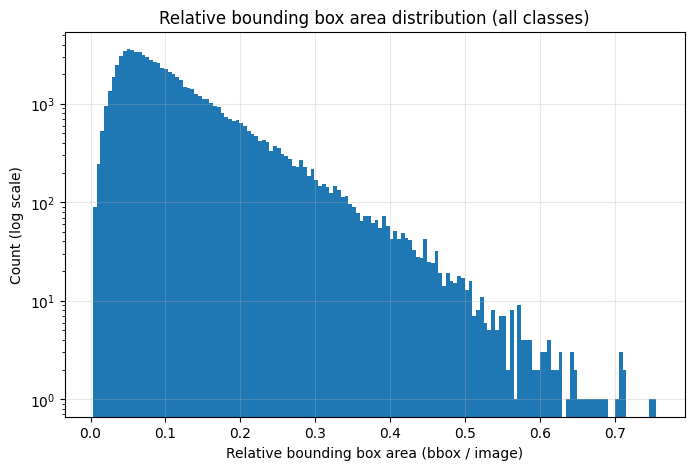

In [56]:
plt.figure(figsize=(8,5))
plt.hist(df["area_rel"], bins=150, log=True)
plt.xlabel("Relative bounding box area (bbox / image)")
plt.ylabel("Count (log scale)")
plt.title("Relative bounding box area distribution (all classes)")
plt.grid(alpha=0.3)
plt.show()

C:\Users\tomma\AppData\Local\Temp\ipykernel_32392\1776824448.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


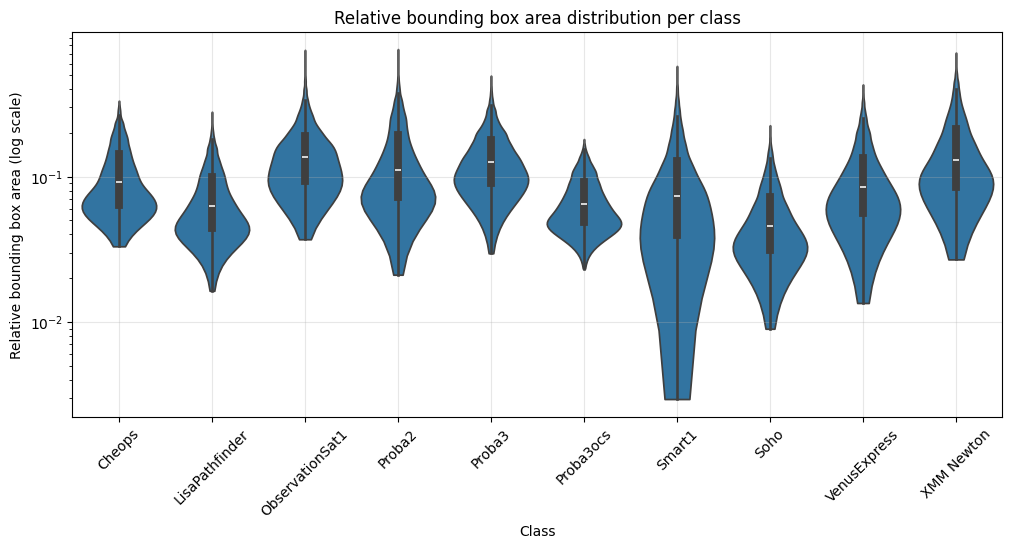

In [57]:
plt.figure(figsize=(12,5))
sns.violinplot(
    data=df,
    x="Class",
    y="area_rel",
    scale="width",
    cut=0
)
plt.yscale("log")
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Relative bounding box area (log scale)")
plt.title("Relative bounding box area distribution per class")
plt.grid(alpha=0.3)
plt.show()

In [58]:
THRESHOLD = 0.01  # 1%

count_small = (
    df[df["area_rel"] < THRESHOLD]
    .groupby("Class")
    .size()
    .reset_index(name="areas < 1%")
    .sort_values("areas < 1%", ascending=False)
)

print(count_small.to_string(index=False))

 Class  areas < 1%
Smart1         164
  Soho           5


## Extreme examples (smallest vs largest bbox)


In [59]:
def find_image_path(cls, img_name):
    # try train first, then val
    for split in ["train", "val"]:
        path = os.path.join(DATASET_ROOT, "images", cls, split, img_name)
        if os.path.exists(path):
            return path
    raise FileNotFoundError(f"Image not found: {img_name}")

def show_image_with_bbox(row: pd.Series, title: str):
    """Display an image with its ground-truth bounding box."""
    img_path = find_image_path(row["Class"], row["Image name"])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    x1, y1, x2, y2 = parse_bbox(row["Bounding box"])
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"{title}\nClass: {row['Class']}, area_rel={row['area_rel']:.6f}")
    plt.axis("off")
    plt.show()

# Smallest and largest bounding boxes in the dataset
row_min = df.loc[df["area_rel"].idxmin()]
row_max = df.loc[df["area_rel"].idxmax()]

print("SMALLEST bounding box (relative area):")
print(row_min[["Class", "Image name", "Bounding box", "area_rel"]])

print("\nLARGEST bounding box (relative area):")
print(row_max[["Class", "Image name", "Bounding box", "area_rel"]])


SMALLEST bounding box (relative area):
Class                         Smart1
Image name       image_06301_img.jpg
Bounding box    (591, 367, 654, 416)
area_rel                    0.002944
Name: 73236, dtype: object

LARGEST bounding box (relative area):
Class                        Proba2
Image name      image_07781_img.jpg
Bounding box       (0, 0, 856, 925)
area_rel                   0.755119
Name: 22623, dtype: object


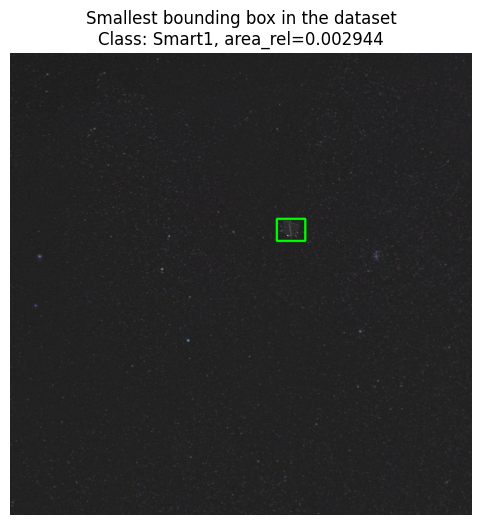

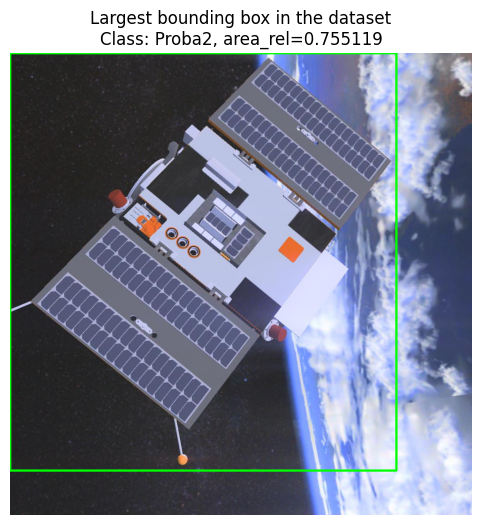

In [60]:
show_image_with_bbox(row_min, title="Smallest bounding box in the dataset")
show_image_with_bbox(row_max, title="Largest bounding box in the dataset")

## Spatial distribution of bbox centers


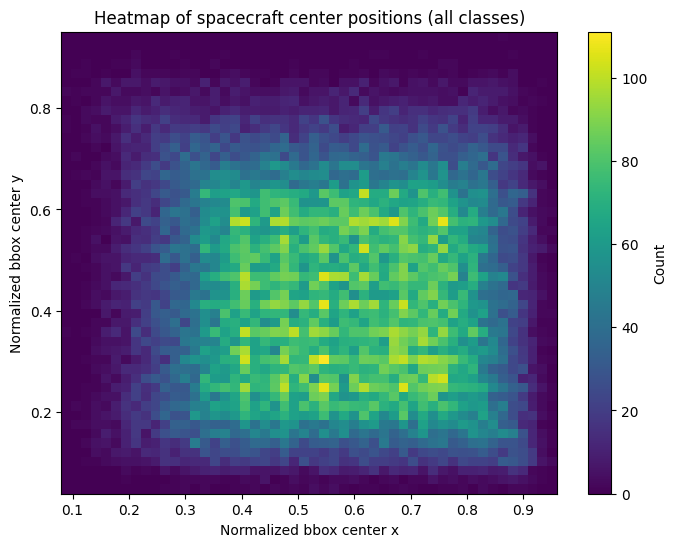

In [61]:
plt.figure(figsize=(8,6))
plt.hist2d(df["cx_rel"], df["cy_rel"], bins=50, cmap="viridis")
plt.colorbar(label="Count")
plt.xlabel("Normalized bbox center x")
plt.ylabel("Normalized bbox center y")
plt.title("Heatmap of spacecraft center positions (all classes)")
plt.show()

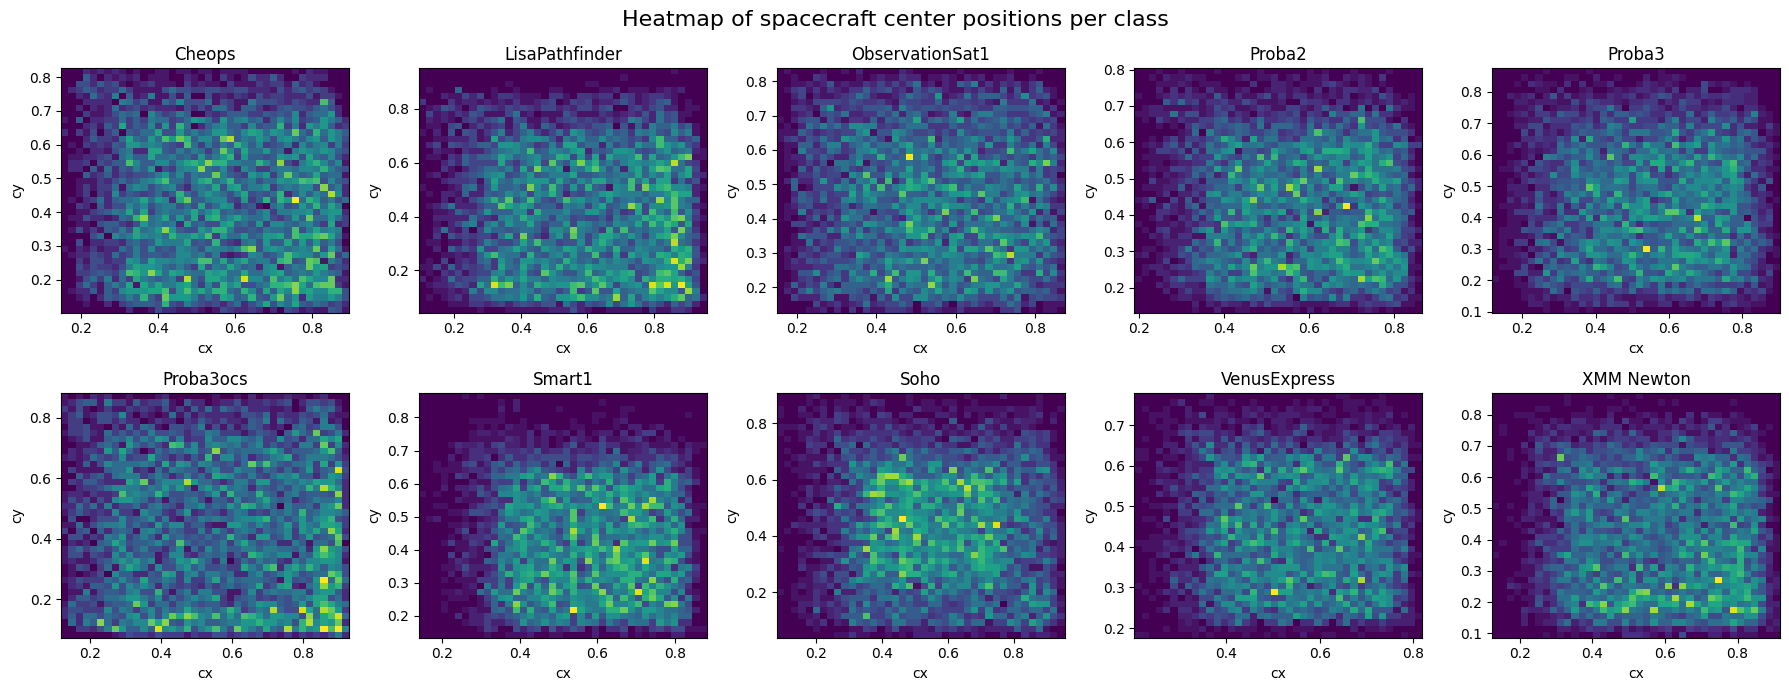

In [62]:
classes = sorted(df["Class"].unique())
rows, cols = 2, 5

plt.figure(figsize=(18,7))

for i, cls in enumerate(classes):
    sub = df[df["Class"] == cls]
    plt.subplot(rows, cols, i+1)
    plt.hist2d(sub["cx_rel"], sub["cy_rel"], bins=40, cmap="viridis")
    plt.title(cls)
    plt.xlabel("cx")
    plt.ylabel("cy")

plt.suptitle("Heatmap of spacecraft center positions per class", fontsize=16)
plt.tight_layout()
plt.show()


# YOLO detection comparison (image_size 128 vs 640)

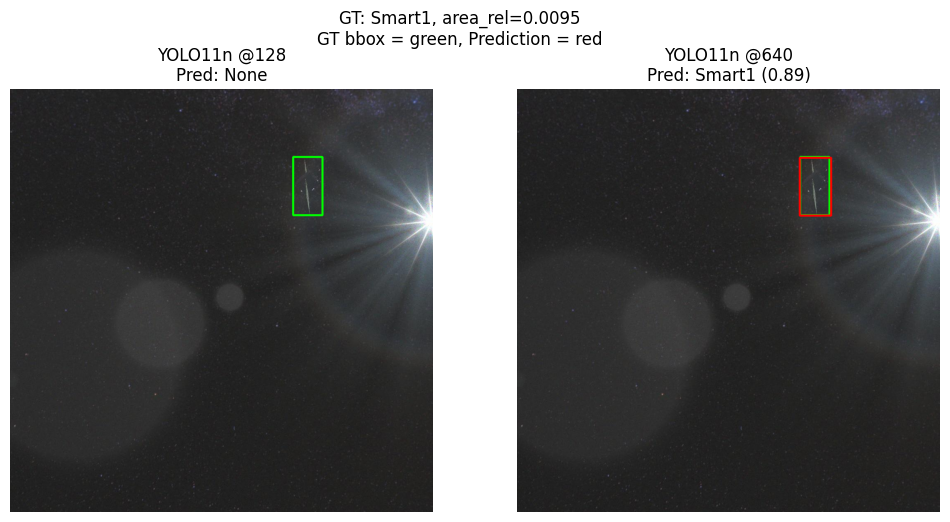

In [78]:
# Load models
model_128 = YOLO("11n_128.pt")
model_640 = YOLO("11n_640.pt")

def compare_models(row):
    """Compare YOLO@128 vs YOLO@640 on a validation sample"""
    img_path = find_image_path(row["Class"], row["Image name"])
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    x1, y1, x2, y2 = parse_bbox(row["Bounding box"])
    gt_class = row["Class"]

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    for ax, model, title in zip(
        axs,
        [model_128, model_640],
        ["YOLO11n @128", "YOLO11n @640"]
    ):
        im = img_rgb.copy()

        # GT bbox (green)
        cv2.rectangle(im, (x1, y1), (x2, y2), (0, 255, 0), 3)

        pred = model.predict(img_path, conf=0.25, verbose=False)[0]
        pred_class, pred_conf = "None", None

        if pred.boxes is not None and len(pred.boxes) > 0:
            best = int(pred.boxes.conf.argmax().item())
            b = pred.boxes.xyxy[best].int().tolist()
            cv2.rectangle(im, (b[0], b[1]), (b[2], b[3]), (255, 0, 0), 3)

            cls_id = int(pred.boxes.cls[best].item())
            pred_class = model.names[cls_id]
            pred_conf = float(pred.boxes.conf[best].item())

        ax.imshow(im)
        ax.axis("off")
        ax.set_title(
            f"{title}\nPred: {pred_class}" if pred_conf is None
            else f"{title}\nPred: {pred_class} ({pred_conf:.2f})"
        )

    plt.suptitle(
        f"GT: {gt_class}, area_rel={row['area_rel']:.4f}\n"
        "GT bbox = green, Prediction = red"
    )
    plt.show()


# I choose one specifc example
row = df.iloc[40716]
compare_models(row)